In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, rcParams, style
style.use('seaborn-darkgrid')
import seaborn as sns
sns.set_style('darkgrid')
from plotly import express as px, graph_objects as go

from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.preprocessing import RobustScaler, StandardScaler, Normalizer, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor

import gc
gc.enable()
from warnings import filterwarnings, simplefilter
filterwarnings('ignore')
simplefilter('ignore')
rcParams['figure.figsize'] = (12, 9)

# 讀取資料

In [2]:
train = pd.read_csv('data/train.csv',parse_dates = ['date'], index_col = 'id')
event = pd.read_csv('data/holidays_events.csv',parse_dates = ['date'])
stores=pd.read_csv('data/stores.csv', index_col = 'store_nbr')
weekday=pd.read_csv('data/weekday.csv')
test=pd.read_csv('data/test.csv',parse_dates = ['date'], index_col = 'id')
submission=pd.read_csv('data/sample_submission.csv')

# 資料前處理

* 將train及test一起處理

In [3]:
train = train.loc[train["date"] >= pd.to_datetime('2016-01-01')]
print(train.shape,test.shape)
train=pd.concat([train,test],axis=0)    
print(train.shape)
train

(1054944, 5) (28512, 4)
(1083456, 5)


,date,store_nbr,family,sales,onpromotion
id,,,,,
1945944,2016-01-01,1,AUTOMOTIVE,0.0,0
1945945,2016-01-01,1,BABY CARE,0.0,0
1945946,2016-01-01,1,BEAUTY,0.0,0
1945947,2016-01-01,1,BEVERAGES,0.0,0
1945948,2016-01-01,1,BOOKS,0.0,0
...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,NaN,1
3029396,2017-08-31,9,PREPARED FOODS,NaN,0
3029397,2017-08-31,9,PRODUCE,NaN,1


In [4]:
national_event = event.loc[(event["locale"] == 'National') & (event["transferred"] == False)]
national_event.drop_duplicates(subset=["date"], inplace=True)
local_event = event.loc[(event["locale"] != 'National') & (event["transferred"] == False)]
data=train.merge(national_event,how='left',on='date').set_index(train.index)
data["local_type"] = np.nan


In [5]:
data[["city", "state"]] = np.nan
for id in stores.index:
    data.loc[data["store_nbr"] == id,["city","state"]] = stores.loc[id,["city","state"]].to_list()
data

,date,store_nbr,family,sales,onpromotion,type,locale,locale_name,description,transferred,local_type,city,state
id,,,,,,,,,,,,,
1945944,2016-01-01,1,AUTOMOTIVE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha
1945945,2016-01-01,1,BABY CARE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha
1945946,2016-01-01,1,BEAUTY,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha
1945947,2016-01-01,1,BEVERAGES,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha
1945948,2016-01-01,1,BOOKS,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha
3029396,2017-08-31,9,PREPARED FOODS,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha
3029397,2017-08-31,9,PRODUCE,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha


In [6]:


for id in local_event.index:
    #print(id)
    data.loc[(data["date"] == local_event.at[id,"date"]) 
    & ((data["city"] == local_event.at[id,"locale_name"]) 
    | (data["state"] == local_event.at[id,"locale_name"]) ),"local_type"] = local_event.at[id, "type"]
print(data.shape)


(1083456, 13)


In [7]:
data.loc[data["local_type"].isna() == False]

,date,store_nbr,family,sales,onpromotion,type,locale,locale_name,description,transferred,local_type,city,state
id,,,,,,,,,,,,,
2056197,2016-03-02,52,AUTOMOTIVE,0.0,0,NaN,NaN,NaN,NaN,NaN,Holiday,Manta,Manabi
2056198,2016-03-02,52,BABY CARE,0.0,0,NaN,NaN,NaN,NaN,NaN,Holiday,Manta,Manabi
2056199,2016-03-02,52,BEAUTY,0.0,0,NaN,NaN,NaN,NaN,NaN,Holiday,Manta,Manabi
2056200,2016-03-02,52,BEVERAGES,0.0,0,NaN,NaN,NaN,NaN,NaN,Holiday,Manta,Manabi
2056201,2016-03-02,52,BOOKS,0.0,0,NaN,NaN,NaN,NaN,NaN,Holiday,Manta,Manabi
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3016657,2017-08-24,50,POULTRY,NaN,0,NaN,NaN,NaN,NaN,NaN,Holiday,Ambato,Tungurahua
3016658,2017-08-24,50,PREPARED FOODS,NaN,0,NaN,NaN,NaN,NaN,NaN,Holiday,Ambato,Tungurahua
3016659,2017-08-24,50,PRODUCE,NaN,2,NaN,NaN,NaN,NaN,NaN,Holiday,Ambato,Tungurahua


In [8]:
train

,date,store_nbr,family,sales,onpromotion
id,,,,,
1945944,2016-01-01,1,AUTOMOTIVE,0.0,0
1945945,2016-01-01,1,BABY CARE,0.0,0
1945946,2016-01-01,1,BEAUTY,0.0,0
1945947,2016-01-01,1,BEVERAGES,0.0,0
1945948,2016-01-01,1,BOOKS,0.0,0
...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,NaN,1
3029396,2017-08-31,9,PREPARED FOODS,NaN,0
3029397,2017-08-31,9,PRODUCE,NaN,1


In [9]:
data

,date,store_nbr,family,sales,onpromotion,type,locale,locale_name,description,transferred,local_type,city,state
id,,,,,,,,,,,,,
1945944,2016-01-01,1,AUTOMOTIVE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha
1945945,2016-01-01,1,BABY CARE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha
1945946,2016-01-01,1,BEAUTY,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha
1945947,2016-01-01,1,BEVERAGES,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha
1945948,2016-01-01,1,BOOKS,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha
3029396,2017-08-31,9,PREPARED FOODS,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha
3029397,2017-08-31,9,PRODUCE,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha


* 增加星期幾的feature

In [10]:

#data["weeday"] = data["date"].dt.weekday
#weekday = pd.get_dummies(data["date"].dt.weekday, prefix='weekday')
data["weekday"] = data["date"].dt.weekday
data["is_weekend"] = data["weekday"].copy()

In [11]:
data.loc[data["weekday"] < 5,"is_weekend"]= 0
data.loc[data["weekday"] >= 5, "is_weekend"] = 1
data

,date,store_nbr,family,sales,onpromotion,type,locale,locale_name,description,transferred,local_type,city,state,weekday,is_weekend
id,,,,,,,,,,,,,,,
1945944,2016-01-01,1,AUTOMOTIVE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,4,0
1945945,2016-01-01,1,BABY CARE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,4,0
1945946,2016-01-01,1,BEAUTY,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,4,0
1945947,2016-01-01,1,BEVERAGES,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,4,0
1945948,2016-01-01,1,BOOKS,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,3,0
3029396,2017-08-31,9,PREPARED FOODS,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,3,0
3029397,2017-08-31,9,PRODUCE,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,3,0


In [12]:
'''
day = pd.get_dummies(data["date"].dt.day, prefix='day') 
month = pd.get_dummies(data["date"].dt.month, prefix='month')
year = pd.get_dummies(data["date"].dt.year, prefix='year')
'''
day = data["date"].dt.day
month = data["date"].dt.month
year = data["date"].dt.year
data = pd.concat([data,year,month,day],axis=1)
data

,date,store_nbr,family,sales,onpromotion,type,locale,locale_name,description,transferred,local_type,city,state,weekday,is_weekend,date,date,date
id,,,,,,,,,,,,,,,,,,
1945944,2016-01-01,1,AUTOMOTIVE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,4,0,2016,1,1
1945945,2016-01-01,1,BABY CARE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,4,0,2016,1,1
1945946,2016-01-01,1,BEAUTY,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,4,0,2016,1,1
1945947,2016-01-01,1,BEVERAGES,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,4,0,2016,1,1
1945948,2016-01-01,1,BOOKS,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,4,0,2016,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,3,0,2017,8,31
3029396,2017-08-31,9,PREPARED FOODS,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,3,0,2017,8,31
3029397,2017-08-31,9,PRODUCE,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,3,0,2017,8,31


* 將日期是否為各類events做one hot encode

In [13]:
  
Holiday = pd.get_dummies(data.type, prefix='type')
data=data.drop(columns=['type','description','transferred','locale','locale_name'])
data=pd.concat([data,Holiday],axis=1)
data

,date,store_nbr,family,sales,onpromotion,local_type,city,state,weekday,is_weekend,date,date,date,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day
id,,,,,,,,,,,,,,,,,,,
1945944,2016-01-01,1,AUTOMOTIVE,0.0,0,NaN,Quito,Pichincha,4,0,2016,1,1,0,0,0,1,0,0
1945945,2016-01-01,1,BABY CARE,0.0,0,NaN,Quito,Pichincha,4,0,2016,1,1,0,0,0,1,0,0
1945946,2016-01-01,1,BEAUTY,0.0,0,NaN,Quito,Pichincha,4,0,2016,1,1,0,0,0,1,0,0
1945947,2016-01-01,1,BEVERAGES,0.0,0,NaN,Quito,Pichincha,4,0,2016,1,1,0,0,0,1,0,0
1945948,2016-01-01,1,BOOKS,0.0,0,NaN,Quito,Pichincha,4,0,2016,1,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,NaN,1,NaN,Quito,Pichincha,3,0,2017,8,31,0,0,0,0,0,0
3029396,2017-08-31,9,PREPARED FOODS,NaN,0,NaN,Quito,Pichincha,3,0,2017,8,31,0,0,0,0,0,0
3029397,2017-08-31,9,PRODUCE,NaN,1,NaN,Quito,Pichincha,3,0,2017,8,31,0,0,0,0,0,0


In [14]:
local_Holiday = pd.get_dummies(data.local_type, prefix='local_type')
data=data.drop(columns=['local_type'])
data=pd.concat([data,local_Holiday],axis=1)
data

,date,store_nbr,family,sales,onpromotion,city,state,weekday,is_weekend,date,...,date,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day,local_type_Additional,local_type_Holiday,local_type_Transfer
id,,,,,,,,,,,,,,,,,,,,,
1945944,2016-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,4,0,2016,...,1,0,0,0,1,0,0,0,0,0
1945945,2016-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,4,0,2016,...,1,0,0,0,1,0,0,0,0,0
1945946,2016-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,4,0,2016,...,1,0,0,0,1,0,0,0,0,0
1945947,2016-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,4,0,2016,...,1,0,0,0,1,0,0,0,0,0
1945948,2016-01-01,1,BOOKS,0.0,0,Quito,Pichincha,4,0,2016,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,NaN,1,Quito,Pichincha,3,0,2017,...,31,0,0,0,0,0,0,0,0,0
3029396,2017-08-31,9,PREPARED FOODS,NaN,0,Quito,Pichincha,3,0,2017,...,31,0,0,0,0,0,0,0,0,0
3029397,2017-08-31,9,PRODUCE,NaN,1,Quito,Pichincha,3,0,2017,...,31,0,0,0,0,0,0,0,0,0


In [15]:
family=pd.get_dummies(data.family, prefix='family')
data=data.drop(columns=['family'])
data=pd.concat([data,family],axis=1)
data

,date,store_nbr,sales,onpromotion,city,state,weekday,is_weekend,date,date,...,family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD
id,,,,,,,,,,,,,,,,,,,,,
1945944,2016-01-01,1,0.0,0,Quito,Pichincha,4,0,2016,1,...,0,0,0,0,0,0,0,0,0,0
1945945,2016-01-01,1,0.0,0,Quito,Pichincha,4,0,2016,1,...,0,0,0,0,0,0,0,0,0,0
1945946,2016-01-01,1,0.0,0,Quito,Pichincha,4,0,2016,1,...,0,0,0,0,0,0,0,0,0,0
1945947,2016-01-01,1,0.0,0,Quito,Pichincha,4,0,2016,1,...,0,0,0,0,0,0,0,0,0,0
1945948,2016-01-01,1,0.0,0,Quito,Pichincha,4,0,2016,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,2017-08-31,9,NaN,1,Quito,Pichincha,3,0,2017,8,...,0,0,0,0,0,1,0,0,0,0
3029396,2017-08-31,9,NaN,0,Quito,Pichincha,3,0,2017,8,...,0,0,0,0,0,0,1,0,0,0
3029397,2017-08-31,9,NaN,1,Quito,Pichincha,3,0,2017,8,...,0,0,0,0,0,0,0,1,0,0


* 對store number做 one hot code

In [16]:
store_nbr = pd.get_dummies(data.store_nbr, prefix='store_nbr')
data=data.drop(columns=['store_nbr'])
data=pd.concat([data,store_nbr],axis=1)
data

,date,sales,onpromotion,city,state,weekday,is_weekend,date,date,date,...,store_nbr_45,store_nbr_46,store_nbr_47,store_nbr_48,store_nbr_49,store_nbr_50,store_nbr_51,store_nbr_52,store_nbr_53,store_nbr_54
id,,,,,,,,,,,,,,,,,,,,,
1945944,2016-01-01,0.0,0,Quito,Pichincha,4,0,2016,1,1,...,0,0,0,0,0,0,0,0,0,0
1945945,2016-01-01,0.0,0,Quito,Pichincha,4,0,2016,1,1,...,0,0,0,0,0,0,0,0,0,0
1945946,2016-01-01,0.0,0,Quito,Pichincha,4,0,2016,1,1,...,0,0,0,0,0,0,0,0,0,0
1945947,2016-01-01,0.0,0,Quito,Pichincha,4,0,2016,1,1,...,0,0,0,0,0,0,0,0,0,0
1945948,2016-01-01,0.0,0,Quito,Pichincha,4,0,2016,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,2017-08-31,NaN,1,Quito,Pichincha,3,0,2017,8,31,...,0,0,0,0,0,0,0,0,0,0
3029396,2017-08-31,NaN,0,Quito,Pichincha,3,0,2017,8,31,...,0,0,0,0,0,0,0,0,0,0
3029397,2017-08-31,NaN,1,Quito,Pichincha,3,0,2017,8,31,...,0,0,0,0,0,0,0,0,0,0


In [17]:
from sklearn.preprocessing import LabelEncoder # 匯入 Label Encoder

le = LabelEncoder()                            
le.fit(data['city'])                         
data['city'] = le.transform(data['city'])  
le.fit(data['state'])                         
data['state'] = le.transform(data['state'])  
data

,date,sales,onpromotion,city,state,weekday,is_weekend,date,date,date,...,store_nbr_45,store_nbr_46,store_nbr_47,store_nbr_48,store_nbr_49,store_nbr_50,store_nbr_51,store_nbr_52,store_nbr_53,store_nbr_54
id,,,,,,,,,,,,,,,,,,,,,
1945944,2016-01-01,0.0,0,18,12,4,0,2016,1,1,...,0,0,0,0,0,0,0,0,0,0
1945945,2016-01-01,0.0,0,18,12,4,0,2016,1,1,...,0,0,0,0,0,0,0,0,0,0
1945946,2016-01-01,0.0,0,18,12,4,0,2016,1,1,...,0,0,0,0,0,0,0,0,0,0
1945947,2016-01-01,0.0,0,18,12,4,0,2016,1,1,...,0,0,0,0,0,0,0,0,0,0
1945948,2016-01-01,0.0,0,18,12,4,0,2016,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,2017-08-31,NaN,1,18,12,3,0,2017,8,31,...,0,0,0,0,0,0,0,0,0,0
3029396,2017-08-31,NaN,0,18,12,3,0,2017,8,31,...,0,0,0,0,0,0,0,0,0,0
3029397,2017-08-31,NaN,1,18,12,3,0,2017,8,31,...,0,0,0,0,0,0,0,0,0,0


In [18]:
data.describe()

,sales,onpromotion,city,state,weekday,is_weekend,date,date,date,type_Additional,...,store_nbr_45,store_nbr_46,store_nbr_47,store_nbr_48,store_nbr_49,store_nbr_50,store_nbr_51,store_nbr_52,store_nbr_53,store_nbr_54
count,1.054944e+06,1.083456e+06,1.083456e+06,1.083456e+06,1.083456e+06,1.083456e+06,1.083456e+06,1.083456e+06,1.083456e+06,1.083456e+06,...,1.083456e+06,1.083456e+06,1.083456e+06,1.083456e+06,1.083456e+06,1.083456e+06,1.083456e+06,1.083456e+06,1.083456e+06,1.083456e+06
mean,4.577225e+02,5.965014e+00,1.255556e+01,8.796296e+00,2.995066e+00,2.845395e-01,2.016400e+03,5.710526e+00,1.572039e+01,1.315789e-02,...,1.851852e-02,1.851852e-02,1.851852e-02,1.851852e-02,1.851852e-02,1.851852e-02,1.851852e-02,1.851852e-02,1.851852e-02,1.851852e-02
std,1.317155e+03,1.816017e+01,6.264739e+00,4.165022e+00,1.997938e+00,4.511950e-01,4.898309e-01,3.187418e+00,8.802522e+00,1.139508e-01,...,1.348169e-01,1.348169e-01,1.348169e-01,1.348169e-01,1.348169e-01,1.348169e-01,1.348169e-01,1.348169e-01,1.348169e-01,1.348169e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.016000e+03,1.000000e+00,1.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,0.000000e+00,8.000000e+00,6.000000e+00,1.000000e+00,0.000000e+00,2.016000e+03,3.000000e+00,8.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.400000e+01,0.000000e+00,1.400000e+01,1.000000e+01,3.000000e+00,0.000000e+00,2.016000e+03,6.000000e+00,1.600000e+01,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.620000e+02,3.000000e+00,1.800000e+01,1.200000e+01,5.000000e+00,1.000000e+00,2.017000e+03,8.000000e+00,2.300000e+01,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.247170e+05,7.410000e+02,2.100000e+01,1.500000e+01,6.000000e+00,1.000000e+00,2.017000e+03,1.200000e+01,3.100000e+01,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [19]:
data.drop(data[(data['type_Event'] ==1) ].index, inplace=True)
data.drop(["date"],axis='columns',inplace=True)

In [20]:
test=data.loc[(data.index >= 3000888)]

data=data.loc[(data.index < 3000888) ]

In [21]:
data

,sales,onpromotion,city,state,weekday,is_weekend,type_Additional,type_Bridge,type_Event,type_Holiday,...,store_nbr_45,store_nbr_46,store_nbr_47,store_nbr_48,store_nbr_49,store_nbr_50,store_nbr_51,store_nbr_52,store_nbr_53,store_nbr_54
id,,,,,,,,,,,,,,,,,,,,,
1945944,0.000,0,18,12,4,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1945945,0.000,0,18,12,4,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1945946,0.000,0,18,12,4,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1945947,0.000,0,18,12,4,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1945948,0.000,0,18,12,4,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,438.133,0,18,12,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3000884,154.553,1,18,12,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3000885,2419.729,148,18,12,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
test

,sales,onpromotion,city,state,weekday,is_weekend,type_Additional,type_Bridge,type_Event,type_Holiday,...,store_nbr_45,store_nbr_46,store_nbr_47,store_nbr_48,store_nbr_49,store_nbr_50,store_nbr_51,store_nbr_52,store_nbr_53,store_nbr_54
id,,,,,,,,,,,,,,,,,,,,,
3000888,NaN,0,18,12,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3000889,NaN,0,18,12,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3000890,NaN,2,18,12,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3000891,NaN,20,18,12,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3000892,NaN,0,18,12,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,NaN,1,18,12,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3029396,NaN,0,18,12,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3029397,NaN,1,18,12,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
'''
rcParams['figure.figsize'] = (120,90)
sns.heatmap(data.corr().abs(), vmin=0, annot = True, fmt='.2f', vmax=1, linewidths=.3)
'''

"\nrcParams['figure.figsize'] = (120,90)\nsns.heatmap(data.corr().abs(), vmin=0, annot = True, fmt='.2f', vmax=1, linewidths=.3)\n"

In [24]:


X = data.drop(['sales'],axis = 1)
y = data['sales']
X

,onpromotion,city,state,weekday,is_weekend,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,...,store_nbr_45,store_nbr_46,store_nbr_47,store_nbr_48,store_nbr_49,store_nbr_50,store_nbr_51,store_nbr_52,store_nbr_53,store_nbr_54
id,,,,,,,,,,,,,,,,,,,,,
1945944,0,18,12,4,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1945945,0,18,12,4,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1945946,0,18,12,4,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1945947,0,18,12,4,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1945948,0,18,12,4,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,0,18,12,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3000884,1,18,12,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3000885,148,18,12,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
y

id
1945944       0.000
1945945       0.000
1945946       0.000
1945947       0.000
1945948       0.000
             ...   
3000883     438.133
3000884     154.553
3000885    2419.729
3000886     121.000
3000887      16.000
Name: sales, Length: 997920, dtype: float64

In [26]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error as rmsle
from sklearn.tree import DecisionTreeRegressor
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
DTR = DecisionTreeRegressor(random_state = 42)


In [27]:
DTR.fit(X_train,y_train)
predict_RFR = DTR.predict(X_test)

In [28]:
print(f"RMSLE: {(rmsle(y_test, predict_RFR))*100:0.2f}%")

RMSLE: 44.59%


In [29]:
test=test.drop(['sales'],axis = 1)


In [30]:
predict_RFR_sub = DTR.predict(test)

In [31]:
predict_RFR_sub.shape

(28512,)

In [32]:
submission['sales'] = predict_RFR_sub
submission.to_csv('./submission.csv', index = False)
submission.head(10)

,id,sales
0,3000888,4.684211
1,3000889,0.000000
2,3000890,6.000000
3,3000891,2457.000000
4,3000892,0.471698
5,3000893,494.802000
6,3000894,18.127660
7,3000895,898.000000
8,3000896,945.000000
9,3000897,197.441000


In [33]:
test2=pd.read_csv('data/test.csv',parse_dates = ['date'], index_col = 'id')

In [34]:
import seaborn as sb

temp = submission.copy()
temp=temp.set_index("id")
temp[["date"]] = test2[["date"]]
temp = temp.set_index("date")
temp

,sales
date,
2017-08-16,4.684211
2017-08-16,0.000000
2017-08-16,6.000000
2017-08-16,2457.000000
2017-08-16,0.471698
...,...
2017-08-31,339.838214
2017-08-31,104.354193
2017-08-31,1157.655000


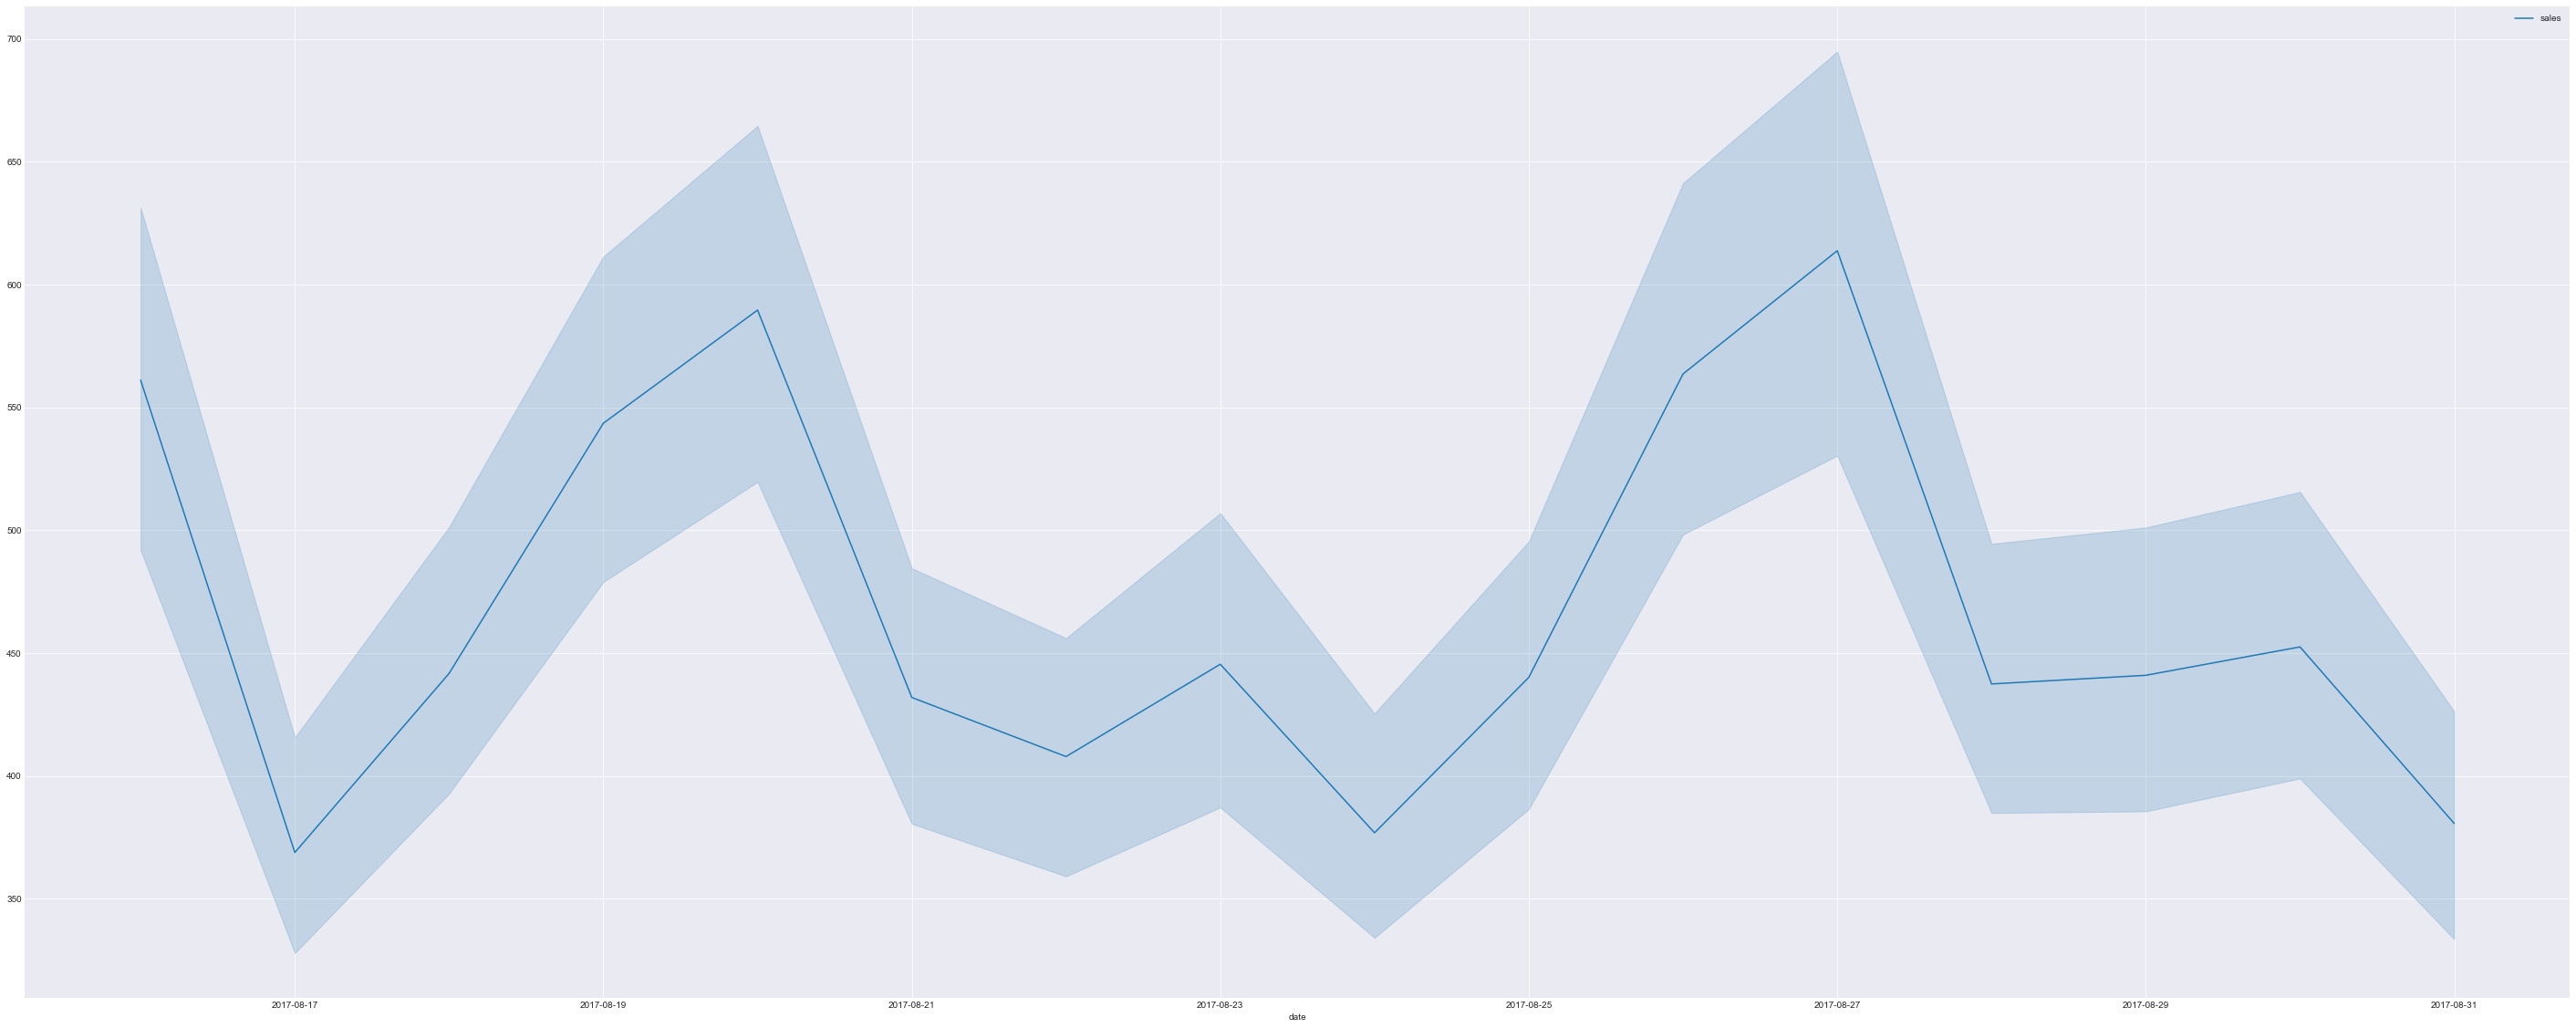

In [35]:
plt.figure(figsize=(50,20))
sb.lineplot(data=temp)
plt.show()
